# Penguins and turtles classificator


## Data description

Dataset is split 50:50 between images of turtles and penguins. Each image contains exactly one instance of an object. Accompanying annotation information is a list of dictionaries. Bounding box coordinates are provided in Pascal VOC format. Category IDs include 1 (penguin) and 2 (turtle).

## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D,
                                     AvgPool2D,
                                     MaxPooling2D,
                                     Dense,
                                     Flatten,
                                     BatchNormalization,
                                     GlobalAveragePooling2D,
                                     Activation,
                                     Dropout)

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0, Xception

from sklearn.metrics import (confusion_matrix,
                             precision_score,
                             recall_score)


from tensorflow.keras.utils import img_to_array, load_img
from keras.api._v2.keras import callbacks

from joblib import Parallel, delayed
import joblib
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-pastel')
RANDOM_STATE = 42

In [ ]:
def read_anotations(path, category):
  anotations =  pd.read_json(path)
  display(anotations.head(10))

  print('In the sample of :', len(anotations[category].unique()), 'classes')
  print()

  anotations.info()
  print()

  print('Quantity of missing values:')
  print(anotations.isna().sum())
  print()

  print('Number of values of each class in the sample:')
  print(anotations[category].value_counts())

  return anotations

In [ ]:
train_anotations = read_anotations('/content/drive/MyDrive/penguins_and_turtles/train_annotations', 'category_id')

id  image_id  category_id                  bbox    area segmentation  \
0   0         0            1   [119, 25, 205, 606]  124230           []   
1   1         1            1   [131, 82, 327, 440]  143880           []   
2   2         2            2  [225, 298, 198, 185]   36630           []   
3   3         3            2  [468, 109, 172, 193]   33196           []   
4   4         4            1   [14, 242, 611, 154]   94094           []   
5   5         5            1   [18, 110, 439, 461]  202379           []   
6   6         6            1   [318, 62, 321, 500]  160500           []   
7   7         7            2  [154, 255, 462, 366]  169092           []   
8   8         8            1  [328, 297, 246, 343]   84378           []   
9   9         9            2  [163, 215, 345, 265]   91425           []   

   iscrowd  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0

In the sample of : 2 classes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            500 non-null    int64 
 1   image_id      500 non-null    int64 
 2   category_id   500 non-null    int64 
 3   bbox          500 non-null    object
 4   area          500 non-null    int64 
 5   segmentation  500 non-null    object
 6   iscrowd       500 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 27.5+ KB

Quantity of missing values:
id              0
image_id        0
category_id     0
bbox            0
area            0
segmentation    0
iscrowd         0
dtype: int64

Number of values of each class in the sample:
1    250
2    250
Name: category_id, dtype: int64


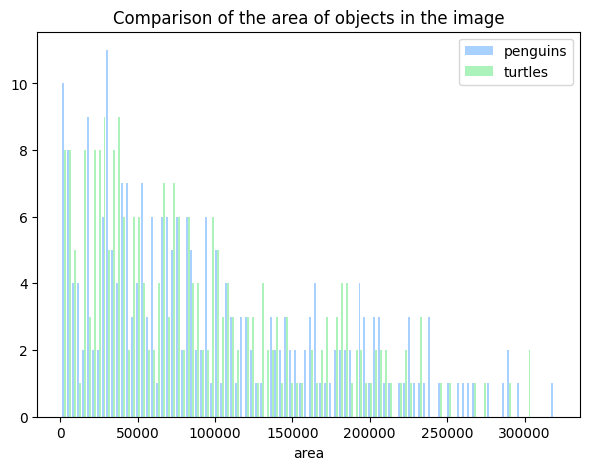

In [ ]:
fig = plt.figure(figsize = (7, 5))
plt.hist(
    [train_anotations[train_anotations['category_id'] == 1].area,
    train_anotations[train_anotations['category_id'] == 2].area],
    bins = 100,
    alpha=0.8,
    label = ['penguins', 'turtles']
)
plt.xlabel('area')
plt.legend(loc='upper right');
plt.title('Comparison of the area of objects in the image');


**The objects are identical in area. There are no big differences.**

In [ ]:
# data for testing

test_anotations = read_anotations('/content/drive/MyDrive/penguins_and_turtles/valid_annotations', 'category_id')

id  image_id  category_id                  bbox    area segmentation  \
0   0         0            1   [227, 93, 298, 525]  156450           []   
1   1         1            2  [211, 198, 428, 259]  110852           []   
2   2         2            2    [0, 243, 512, 267]  136704           []   
3   3         3            1  [128, 178, 457, 354]  161778           []   
4   4         4            1  [168, 131, 296, 469]  138824           []   
5   5         5            1    [6, 121, 445, 471]  209595           []   
6   6         6            2   [63, 161, 438, 322]  141036           []   
7   7         7            1  [188, 252, 254, 276]   70104           []   
8   8         8            1  [375, 237, 189, 315]   59535           []   
9   9         9            1  [364, 223, 141, 246]   34686           []   

   iscrowd  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0

In the sample of : 2 classes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            72 non-null     int64 
 1   image_id      72 non-null     int64 
 2   category_id   72 non-null     int64 
 3   bbox          72 non-null     object
 4   area          72 non-null     int64 
 5   segmentation  72 non-null     object
 6   iscrowd       72 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 4.1+ KB

Quantity of missing values:
id              0
image_id        0
category_id     0
bbox            0
area            0
segmentation    0
iscrowd         0
dtype: int64

Number of values of each class in the sample:
1    36
2    36
Name: category_id, dtype: int64


In [ ]:
# change numbers on image names in column

def change_values(path, anotation):
  names_images = sorted(os.listdir(path))

  for i in range(len(names_images)):
    anotation['image_id'][i] = names_images[i]

  for i in range(len(names_images)):
    anotation['category_id'][i] = str(anotation['category_id'][i])

  return anotation

In [ ]:
train_anotations = change_values('/content/drive/MyDrive/penguins_and_turtles/train', train_anotations)
display(train_anotations.sample(5))

id          image_id category_id                  bbox    area  \
426  426  image_id_426.jpg           2   [70, 353, 223, 130]   28990   
250  250  image_id_250.jpg           1  [260, 306, 114, 173]   19722   
224  224  image_id_224.jpg           1  [117, 149, 247, 491]  121277   
342  342  image_id_342.jpg           2     [2, 89, 638, 473]  301774   
225  225  image_id_225.jpg           2   [170, 276, 301, 86]   25886   

    segmentation  iscrowd  
426           []        0  
250           []        0  
224           []        0  
342           []        0  
225           []        0

In [ ]:
test_anotations = change_values('/content/drive/MyDrive/penguins_and_turtles/valid', test_anotations)

## Modeling and training



In [ ]:
# create a generator

generator = ImageDataGenerator(rescale=1/255,
                               # augmentation
                               horizontal_flip=True,
                               rotation_range=30,
                               zoom_range=0.2,
                               validation_split = 0.2)

In [ ]:
def input_images(anotation, path, sample_for, image_size, batch):
  images = generator.flow_from_dataframe(
      anotation,
      directory= path,
      x_col = 'image_id',
      y_col= 'category_id',
      subset = sample_for,
    # numpy array of y_col data
      class_mode = 'categorical',
    # size of images
      target_size = (image_size, image_size),
      batch_size = batch,
      seed=RANDOM_STATE)

  return images

In [ ]:
path_train = '/content/drive/MyDrive/penguins_and_turtles/train'
train_images = input_images(train_anotations, path_train, 'training', 224, 25)

Found 400 validated image filenames belonging to 2 classes.


In [ ]:
valid_images = input_images(train_anotations, path_train, 'validation', 224, 25)

Found 100 validated image filenames belonging to 2 classes.


In [ ]:
features, target = next(train_images)

In [ ]:
print('Input tensor:', features.shape)
print(target.shape)

Input tensor: (25, 224, 224, 3)
(25, 2)


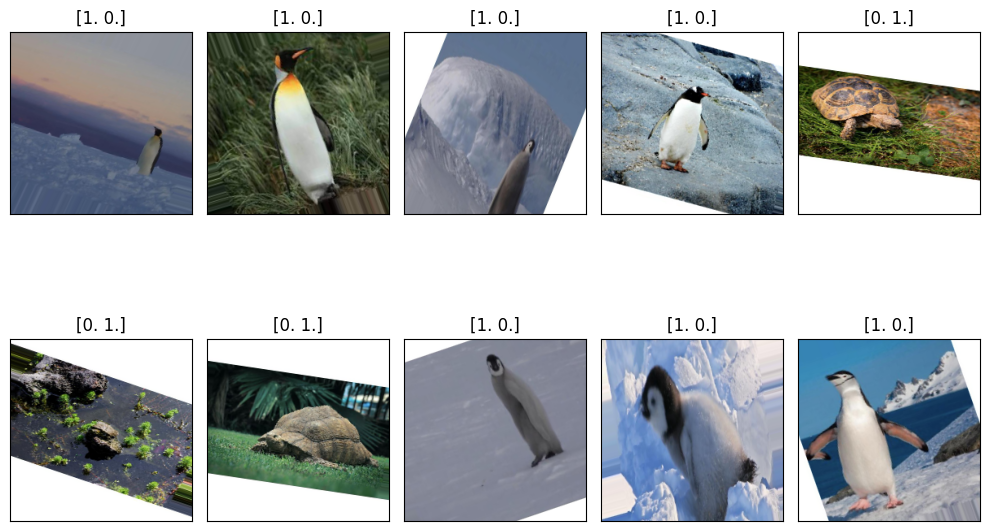

In [ ]:
fig = plt.figure(figsize=(10, 10));
for i in range(10):
  fig.add_subplot(2, 5, i+1);
  plt.imshow(features[i]);
  plt.title(target[i]);
  plt.xticks([]);
  plt.yticks([]);
  plt.tight_layout();

### LeNet architecture

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), input_shape=features.shape[1:], activation='relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.99))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.99))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.99))


model.add(Flatten())

model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 84, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 average_pooling2d (AverageP  (None, 110, 110, 16)     0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 53, 53, 32)       0         
 ePooling2D)                                                     
                                                        

In [ ]:
# saving the model's learning progress

history = tf.keras.callbacks.History()

In [ ]:
%%timeit

model.fit(train_images,
          steps_per_epoch=len(train_images),
          validation_data = valid_images,
          validation_steps = len(valid_images),
          epochs = 20,
          callbacks=[history])

Epoch 1/20
16/16 [==============================] - 42s 2s/step - loss: 2.7592 - accuracy: 0.6275 - val_loss: 1.7613 - val_accuracy: 0.6100
Epoch 2/20
16/16 [==============================] - 31s 2s/step - loss: 2.6382 - accuracy: 0.6775 - val_loss: 2.4578 - val_accuracy: 0.5700
Epoch 3/20
16/16 [==============================] - 33s 2s/step - loss: 1.9142 - accuracy: 0.7375 - val_loss: 1.2043 - val_accuracy: 0.6800
Epoch 4/20
16/16 [==============================] - 30s 2s/step - loss: 1.5253 - accuracy: 0.7475 - val_loss: 1.3697 - val_accuracy: 0.6100
Epoch 5/20
16/16 [==============================] - 29s 2s/step - loss: 1.3082 - accuracy: 0.7900 - val_loss: 3.6843 - val_accuracy: 0.4100
Epoch 6/20
16/16 [==============================] - 33s 2s/step - loss: 1.3601 - accuracy: 0.7325 - val_loss: 1.6989 - val_accuracy: 0.4700
Epoch 7/20
16/16 [==============================] - 30s 2s/step - loss: 1.3671 - accuracy: 0.7375 - val_loss: 4.9788 - val_accuracy: 0.6600
Epoch 8/20
16/16 [==

In [ ]:
with open('history_v5.0.json', 'w') as f:
    json.dump(history.history, f)
joblib.dump(model, 'model_v5.0_img.pkl')

['model_v5.0_img.pkl']

In [ ]:
model = joblib.load('/content/drive/MyDrive/penguins_and_turtles/models/model_v5.0_img.pkl')

In [ ]:
history = pd.read_json('/content/drive/MyDrive/penguins_and_turtles/models/history_v5.0.json')
display(history.tail())

loss  accuracy  val_loss  val_accuracy
155  0.068923    0.9800  1.443285          0.82
156  0.052898    0.9800  1.886785          0.77
157  0.053365    0.9850  1.175363          0.84
158  0.019908    0.9900  1.683355          0.82
159  0.049720    0.9825  1.419129          0.80

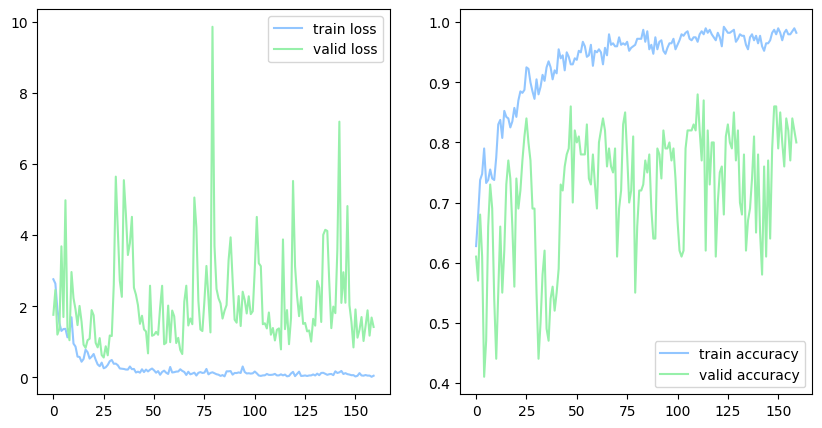

In [ ]:
from matplotlib import legend
fig, ax = plt.subplots(1, 2, figsize = (10, 5));

ax[0].plot(history['loss'], label='train loss');
ax[0].plot(history['val_loss'], label='valid loss');
ax[0].legend();

ax[1].plot(history['accuracy'], label='train accuracy');
ax[1].plot(history['val_accuracy'], label='valid accuracy');
ax[1].legend();

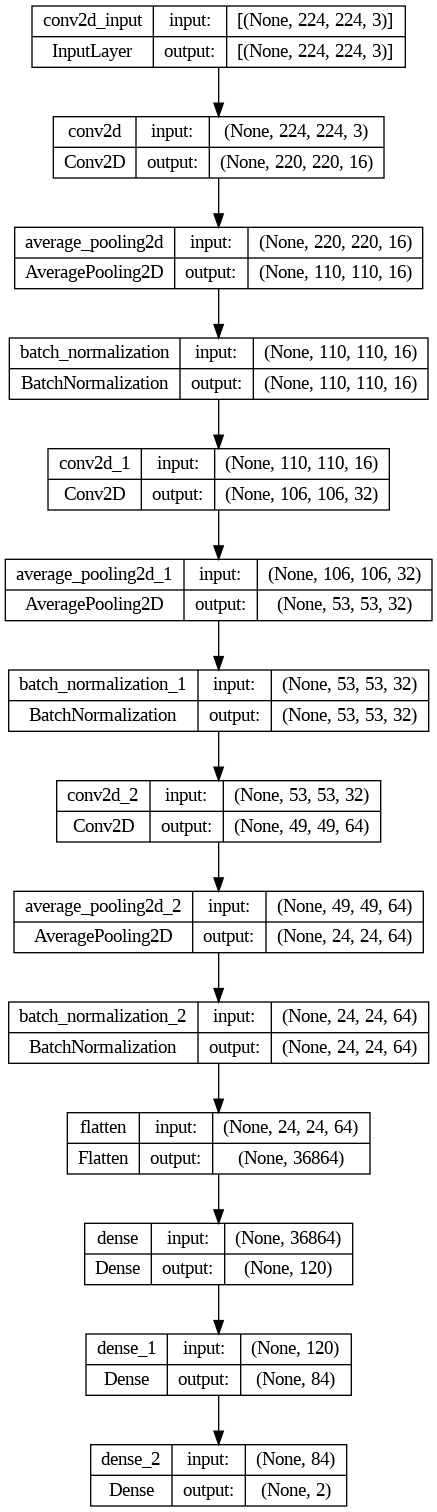

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Conclusion

-  During the training, I experimented with different learning rates.
The highest accuracy is achieved with learning_rate = 0.001.
With learning_rate = 0.01-0.03 accuracy did not exceed 0.7.

- At first glance, it seems that the graphs for the training sample look good, but the validation data shows that the network is very unstable.
Since LeNet contains only 3 convolutional layers, graphs with validation data indicate that the "depth" of the network is insufficient.
That is, I think, to improve the result, we need to deepen the network and "give" the model more layers and time to highlight more obvious distinguishing features between turtles and penguins.

- To further work on the task and save time, I will use the network pre-trained on ImageNet.

### EfficientNetV2B0 backbone


In [ ]:
# number of classes
class_count=2

# learning rate
lr= .001

# input shape of images
img_shape = (224, 224, 3)

backbone=tf.keras.applications.EfficientNetV2B0(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=img_shape,
                                                  pooling='max')
backbone.trainable=True

# output tensor
x=backbone.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)

x=Dropout(rate=.4, seed=RANDOM_STATE)(x)
output=Dense(class_count, activation='softmax')(x)

model_pre=Model(inputs=backbone.input, outputs=output)
model_pre.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
# add 2 callbacks, reduce learning rate on plateau and early stopping

history_pre = tf.keras.callbacks.History()

rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.4,  patience=2,
                                            verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
callbacks=[rlronp, estop, history_pre]


In [ ]:
#%%timeit

history_pre=model_pre.fit(x=train_images, epochs=20, verbose=1, callbacks=callbacks,  validation_data=valid_images,
                          validation_steps=None,  shuffle=True,  initial_epoch=0)

Epoch 1/20
16/16 [==============================] - 64s 4s/step - loss: 1.9219 - accuracy: 0.9925 - val_loss: 1.9469 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - 63s 4s/step - loss: 1.8344 - accuracy: 0.9875 - val_loss: 1.8709 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - 63s 4s/step - loss: 1.7317 - accuracy: 0.9950 - val_loss: 1.7796 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 4/20
16/16 [==============================] - 62s 4s/step - loss: 1.6522 - accuracy: 0.9950 - val_loss: 1.7602 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 5/20
16/16 [==============================] - 64s 4s/step - loss: 1.5659 - accuracy: 0.9975 - val_loss: 1.6227 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/20
16/16 [==============================] - 63s 4s/step - loss: 1.5052 - accuracy: 0.9950 - val_loss: 1.5229 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/20
16/16 [==============================] - 62s 4s/step - loss: 1.4220 - a

In [ ]:
# save the model
import pickle

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history_pre.history, file_pi)
joblib.dump(model_pre, 'model_EfNet_v3.0.pkl')

['model_EfNet_v3.0.pkl']

In [ ]:
with open('/content/drive/MyDrive/penguins_and_turtles/models/trainHistoryDict', 'rb') as file_pi:
    history_pre = pd.DataFrame(pickle.load(file_pi))
display(history_pre.tail(5))

loss  accuracy  val_loss  val_accuracy     lr
29  1.053914    1.0000  1.076537          0.96  0.001
30  1.015847    0.9950  0.984447          0.99  0.001
31  0.959874    0.9950  1.068414          0.88  0.001
32  0.901621    1.0000  0.933194          0.97  0.001
33  0.902182    0.9725  0.987473          0.94  0.001

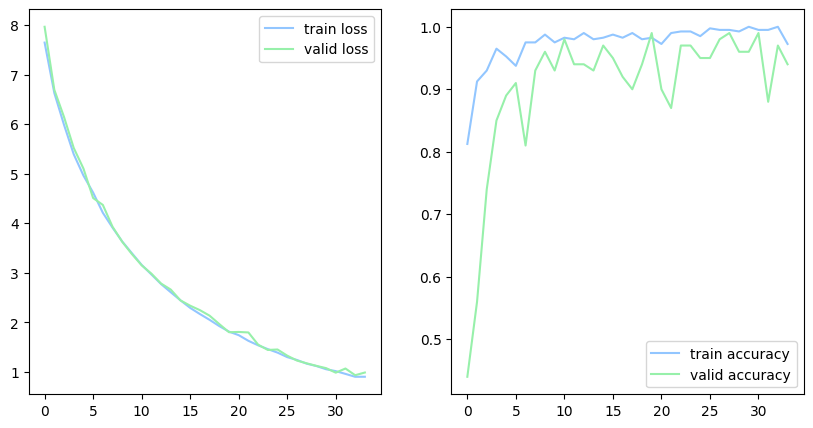

In [ ]:
from matplotlib import legend
fig, ax = plt.subplots(1, 2, figsize = (10, 5));

ax[0].plot(history_pre['loss'], label='train loss');
ax[0].plot(history_pre['val_loss'], label='valid loss');
ax[0].legend();

ax[1].plot(history_pre['accuracy'], label='train accuracy');
ax[1].plot(history_pre['val_accuracy'], label='valid accuracy');
ax[1].legend();

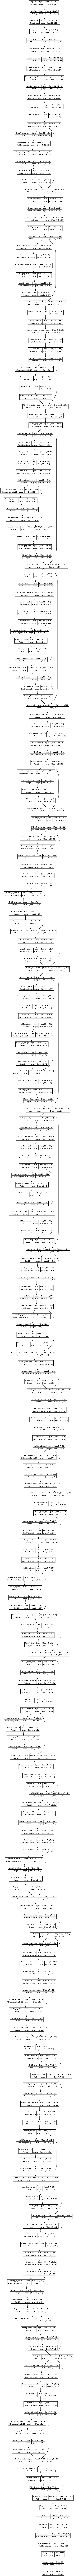

In [ ]:
plot_model(model_pre, to_file='model_pre.png', show_shapes=True, show_layer_names=True)

### Conclusion

- As can be seen from the graphs, EfficieynNetV2B0 has sufficient depth to highlight the characteristic differences between penguins and turtles.

- A 224 by 224 color image is fed to the input, which then passes through a cascade of convolutions.

- Using the **base_model.trainable = True**, I used convolutional layers in training.

- I also changed the part responsible for classification, because initially the network was created to recognize 1000 classes, but I am solving the problem of binary classification (2 classes).

- Thus, after the convolution blocks, I added: BatchNormalization, Dense layer (256 neurons), Dropout, Dense layer (2 neurons) with the "softmax" activation function.

- Using fine-tuning accuracy validation data is 0.95 - 0.98.

## Testing

In [ ]:
test_path = '/content/drive/MyDrive/penguins_and_turtles/valid'
test_anotations = change_values(test_path, test_anotations)
display(test_anotations.sample(5))

id          image_id category_id                  bbox    area  \
3    3  image_id_003.jpg           1  [128, 178, 457, 354]  161778   
35  35  image_id_035.jpg           2  [155, 161, 334, 325]  108550   
5    5  image_id_005.jpg           1    [6, 121, 445, 471]  209595   
28  28  image_id_028.jpg           1  [223, 256, 233, 116]   27028   
57  57  image_id_057.jpg           1  [263, 127, 373, 398]  148454   

   segmentation  iscrowd  
3            []        0  
35           []        0  
5            []        0  
28           []        0  
57           []        0

In [ ]:
test_images = input_images(test_anotations, test_path, None, 224, 12)

Found 72 validated image filenames belonging to 2 classes.


In [ ]:
features_test, target_test = next(test_images)

In [ ]:
# testing model

results = model_pre.evaluate(features_test, target_test)
print(f'test loss, test acc: {results}')

1/1 [==============================] - 0s 386ms/step - loss: 0.9308 - accuracy: 0.9167
test loss, test acc: [0.9307928085327148, 0.9166666865348816]


## Conclusions

It was necessary to create an image classifier.
During experiments with various network parameters, train_accuracy = 0.91 was achieved using a pre-trained EffisienNet and transfer learning for fine-tuning.

What can be done to improve the metric:

1) train the model on an additional number of epochs;

2) add new images and increase the percentage of augmentation;

3) try other network architectures, change the size of the convolution kernel and the counts of filters;

4) increase the size of the input images to highlight more patterns, etc.